In [1]:
%matplotlib inline

import pandas as pd

In [2]:
import numpy as np
import os
import six.moves.urllib as urllib
import sys
import tarfile
import tensorflow as tf
import zipfile

from collections import defaultdict
from io import StringIO
from matplotlib import pyplot as plt
from PIL import Image
from object_detection.utils import label_map_util
from object_detection.utils import visualization_utils as vis_util

In [5]:
# Path to frozen detection graph. This is the actual model that is used for the object detection.
#PATH_TO_CKPT = '/home/bibagimon/tensorflow/workspace/training/trained-inference-graphs/output_inference_graph_v1.pb/frozen_inference_graph.pb'
PATH_TO_CKPT = '/home/bibagimon/CarND-Capstone/detection/trained-inference-graphs/output_inference_graph_v1.pb/frozen_inference_graph.pb'

# List of the strings that is used to add correct label for each box.
PATH_TO_LABELS = os.path.join('training', 'annotations', 'label_map.pbtxt')

# Number of classes to detect
NUM_CLASSES = 3

# Load a (frozen) Tensorflow model into memory.
detection_graph = tf.Graph()
with detection_graph.as_default():
    od_graph_def = tf.GraphDef()
    with tf.gfile.GFile(PATH_TO_CKPT, 'rb') as fid:
        serialized_graph = fid.read()
        od_graph_def.ParseFromString(serialized_graph)
        tf.import_graph_def(od_graph_def, name='')


# Loading label map
# Label maps map indices to category names, so that when our convolution network predicts `5`, we know that this corresponds to `airplane`.  Here we use internal utility functions, but anything that returns a dictionary mapping integers to appropriate string labels would be fine
label_map = label_map_util.load_labelmap(PATH_TO_LABELS)
categories = label_map_util.convert_label_map_to_categories(
    label_map, max_num_classes=NUM_CLASSES, use_display_name=True)
category_index = label_map_util.create_category_index(categories)


# Helper code
def load_image_into_numpy_array(image):
    (im_width, im_height) = image.size
    return np.array(image.getdata()).reshape(
        (im_height, im_width, 3)).astype(np.uint8)

from skimage import io
image_np = io.imread('/home/bibagimon/tensorflow/workspace/data/sim_training_data/sim_data_capture/left0611.jpg')

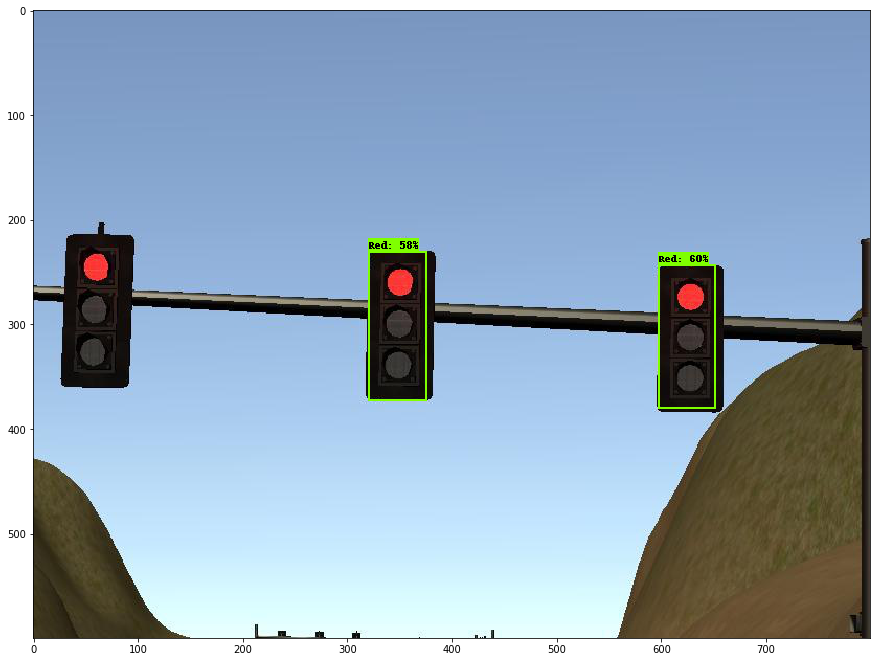

In [6]:
# Detection
with detection_graph.as_default():
    with tf.Session(graph=detection_graph) as sess:
        # Expand dimensions since the model expects images to have shape: [1, None, None, 3]
        image_np_expanded = np.expand_dims(image_np, axis=0)
        # Extract image tensor
        image_tensor = detection_graph.get_tensor_by_name('image_tensor:0')
        # Extract detection boxes
        boxes = detection_graph.get_tensor_by_name('detection_boxes:0')
        # Extract detection scores
        scores = detection_graph.get_tensor_by_name('detection_scores:0')
        # Extract detection classes
        classes = detection_graph.get_tensor_by_name('detection_classes:0')
        # Extract number of detectionsd
        num_detections = detection_graph.get_tensor_by_name(
            'num_detections:0')
        # Actual detection.
        (boxes, scores, classes, num_detections) = sess.run(
            [boxes, scores, classes, num_detections],
            feed_dict={image_tensor: image_np_expanded})
        
        # Visualization of the results of a detection.
        vis_util.visualize_boxes_and_labels_on_image_array(
            image_np,
            np.squeeze(boxes),
            np.squeeze(classes).astype(np.int32),
            np.squeeze(scores),
            category_index,
            use_normalized_coordinates=True,
            line_thickness=2)
        
        import matplotlib.pyplot as plt
        plt.figure(figsize=(15,15))
        plt.imshow(image_np)
        plt.show()